In [1]:
#Imports

## General Imports
import numpy as np

## Visualization
import seaborn
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interactive_output #http://ipywidgets.readthedocs.io/en/latest/index.html
from ipywidgets import IntSlider, FloatSlider, fixed, Checkbox
from ipywidgets import VBox, Label


## Audio Imports
import librosa, librosa.display           #https://librosa.github.io/librosa/index.html
from midiutil import MIDIFile             #http://midiutil.readthedocs.io/en/1.2.1/
import music21
music21.environment.set('musescoreDirectPNGPath', 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe')
from music21.tempo import MetronomeMark   #http://web.mit.edu/music21/
from music21.note import Note, Rest
from music21.stream import Stream
from music21 import metadata
from music21 import instrument
from music21 import midi 
from music21.key import Key


In [2]:
# Configurations

path = 'music/'

arch = [x+".wav" for x in ["star","hb","Test_1","Test_2","exo","tyf1","Mariage"]]

file = arch[1]
Title = 'Cumpleaños feliz'
Composer = ''

## Matplotlib
plt.rc("figure", figsize=(16, 8))

In [3]:
"""
# OG parameters
## Signal Processing 
fs = 44100                               # Sampling Frequency
nfft = 2048                              # length of the FFT window
overlap = 0.5                            # Hop overlap percentage
hop_length = int(nfft*(1-overlap))       # Number of samples between successive frames
n_bins = 72                              # Number of frequency bins
mag_exp = 4                              # Magnitude Exponent
pre_post_max = 6                         # Pre- and post- samples for peak picking
cqt_threshold = -61                      # Threshold for CQT dB levels, all values below threshold are set to -120 dB
"""


#Custom 1
fs = 44100                       
nfft = 2048                        
overlap = 0.5                      
hop_length = int(nfft*(1-overlap))  
n_bins = 72                           
mag_exp = 2                    
pre_post_max = 7                     
cqt_threshold = -55  
"""
fs = 44100                       
nfft = 2048                        
overlap = 0.5                     
hop_length = int(nfft*(1-overlap))  
n_bins = 72                           
mag_exp = 2              
pre_post_max = 7          
cqt_threshold = -64
"""

'\nfs = 44100                       \nnfft = 2048                        \noverlap = 0.5                     \nhop_length = int(nfft*(1-overlap))  \nn_bins = 72                           \nmag_exp = 2              \npre_post_max = 7          \ncqt_threshold = -64\n'

In [4]:
# Load Audio
# Loadinging audio file
filename = path + file
x, fs = librosa.load(filename, sr=None, mono=True)
# Audio data information
print("x Shape=", x.shape)
print("Sample rate fs=", fs)
print("Audio Length in seconds=%d [s]" % (x.shape[0]/fs))
# Playback audio file
ipd.Audio(x, rate=fs)

x Shape= (689664,)
Sample rate fs= 44100
Audio Length in seconds=15 [s]


In [5]:
x, fs = librosa.load(filename, sr=None, mono=True, duration=(x.shape[0]/fs)-1)
# Audio data information
print("x Shape=", x.shape)
print("Sample rate fs=", fs)
print("Audio Length in seconds=%d [s]" % (x.shape[0]/fs))
# Playback audio file
ipd.Audio(x, rate=fs)

x Shape= (645564,)
Sample rate fs= 44100
Audio Length in seconds=14 [s]


In [6]:
# Custom approximation
def aprox(num):
    '32nd'
    if num<0.15:
        return '32nd'
    elif num<0.3:
        return '16th'
    elif num<0.7:
        return 'eighth'
    elif num<1.4:
        return 'quarter'
    elif num<3:
        return 'half'
    else:
        return 'whole'

In [7]:
# CQT
## Function
def calc_cqt(x,fs=fs,hop_length=hop_length, n_bins=n_bins, mag_exp=mag_exp):
    C = librosa.cqt(x, sr=fs, hop_length=hop_length, fmin=None, n_bins=n_bins)
    C_mag = librosa.magphase(C)[0]**mag_exp
    CdB = librosa.core.amplitude_to_db(C_mag ,ref=np.max)
    return CdB

# CQT Threshold
def cqt_thresholded(cqt,thres=cqt_threshold):
    new_cqt=np.copy(cqt)
    new_cqt[new_cqt<thres]=-120
    return new_cqt

# Onset Envelope from Cqt
def calc_onset_env(cqt):
    return librosa.onset.onset_strength(S=cqt, sr=fs, aggregate=np.mean, hop_length=hop_length)

# Onset from Onset Envelope
def calc_onset(cqt, pre_post_max=pre_post_max, backtrack=True):
    onset_env=calc_onset_env(cqt)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env,
                                           sr=fs, units='frames', 
                                           hop_length=hop_length, 
                                           backtrack=backtrack,
                                           pre_max=pre_post_max,
                                           post_max=pre_post_max)
    onset_boundaries = np.concatenate([[0], onset_frames, [cqt.shape[1]]])
    onset_times = librosa.frames_to_time(onset_boundaries, sr=fs, hop_length=hop_length)
    return [onset_times, onset_boundaries, onset_env]

# Convert Seconds to Quarter-Notes
def time_to_beat(duration, tempo):
    return (tempo*duration/60)

# Remap input to 0-1 for Sine Amplitude or to 0-127 for MIDI
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

# Generate Sinewave, MIDI Notes and music21 notes
def generate_sine_midi_note(f0_info, sr, n_duration, round_to_sixtenth=True):
    f0=f0_info[0]
    A=remap(f0_info[1], CdB.min(), CdB.max(), 0, 1)
    duration = librosa.frames_to_time(n_duration, sr=fs, hop_length=hop_length)
    #Generate Midi Note and music21 note
    note_duration = 0.02*np.around(duration/2/0.02) # Round to 2 decimal places for music21 compatibility
    midi_duration = time_to_beat(duration, tempo)
    midi_velocity=int(round(remap(f0_info[1], CdB.min(), CdB.max(), 0, 127)))
    if round_to_sixtenth:
        midi_duration=round(midi_duration*16)/16
    if f0==None:
        midi_note=None
        note_info=Rest(type=mm.secondsToDuration(note_duration).type)
        f0=0
    else:
        midi_note=round(librosa.hz_to_midi(f0))
        #note = Note(librosa.midi_to_note(midi_note).replace('♯','#'), type=mm.secondsToDuration(note_duration).type)
        note = Note(librosa.midi_to_note(midi_note).replace('♯','#'), type=aprox(midi_duration))
        print("type: "+aprox(midi_duration)+" duration: "+str(midi_duration))
        note.volume.velocity = midi_velocity
        note_info = [note]
    midi_info = [midi_note, midi_duration, midi_velocity]
            
    # Generate Sinewave
    n = np.arange(librosa.frames_to_samples(n_duration, hop_length=hop_length ))
    sine_wave = A*np.sin(2*np.pi*f0*n/float(sr))
    return [sine_wave, midi_info, note_info]

#Estimate Pitch
def estimate_pitch(segment, threshold):
    freqs = librosa.cqt_frequencies(n_bins=n_bins, fmin=librosa.note_to_hz('C1'),
                            bins_per_octave=12)
    if segment.max()<threshold:
        return [None, np.mean((np.amax(segment,axis=0)))]
    else:
        f0 = int(np.mean((np.argmax(segment,axis=0))))
    return [freqs[f0], np.mean((np.amax(segment,axis=0)))]

# Generate notes from Pitch estimation
def estimate_pitch_and_notes(x, onset_boundaries, i, sr):
    n0 = onset_boundaries[i]
    n1 = onset_boundaries[i+1]
    f0_info = estimate_pitch(np.mean(x[:,n0:n1],axis=1),threshold=cqt_threshold)
    return generate_sine_midi_note(f0_info, sr, n1-n0)

In [8]:
# Fine Tuning UI
style = {'description_width': 'initial'}
mag_exp_slider=IntSlider(value=mag_exp, min=1, max=32, step=1, 
                         description='mag_exp:',continuous_update=False)

thres_slider=IntSlider(value=cqt_threshold, min=-120, max=0, step=1, 
                                                     description='Threshold:',continuous_update=False)

pre_post_slider=IntSlider(value=pre_post_max, min=1, max=32, step=1, 
                         description='Pre_post_max:',continuous_update=False, style=style)

backtrack_box=Checkbox(value=True,description='backtrack',disabled=False)


def inter_cqt_tuning(mag_exp,thres,pre_post_max, backtrack):
    thres=thres_slider.value
    mag_exp=mag_exp_slider.value
    pre_post_max=pre_post_slider.value
    backtrack=backtrack_box.value
    global CdB
    CdB = calc_cqt(x,fs,hop_length, n_bins, mag_exp)
    plt.figure()
    new_cqt=cqt_thresholded(CdB,thres)
    librosa.display.specshow(new_cqt, sr=fs, hop_length=hop_length, x_axis='time', y_axis='cqt_note', cmap='coolwarm')
    plt.ylim([librosa.note_to_hz('B2'),librosa.note_to_hz('B6')])
    global onsets
    onsets=calc_onset(new_cqt,pre_post_max, backtrack)
    plt.vlines(onsets[0], 0, fs/2, color='k', alpha=0.8)
    plt.title("CQT - Sweet Child O' Mine Intro")
    plt.colorbar()
    plt.show()
    
    
# Display UI
out = interactive_output(inter_cqt_tuning,  {'mag_exp': mag_exp_slider, 'thres': thres_slider, 
                                             'pre_post_max': pre_post_slider, 'backtrack':backtrack_box})
ui = VBox([mag_exp_slider, thres_slider, pre_post_slider, backtrack_box])
display(ui, out)

Output()

In [9]:
# Estimate Tempo
tempo, beats=librosa.beat.beat_track(y=None, sr=fs, onset_envelope=onsets[2], hop_length=hop_length,
               start_bpm=120.0, tightness=100, trim=True, bpm=None,
               units='frames')
tempo=int(2*round(tempo/2))
mm = MetronomeMark(referent='quarter', number=tempo)

print(tempo)

100


In [10]:
# Array of music information - Sinewave, MIDI Notes and muisc21 Notes
notes=[]
for i in range(len(onsets[1])-1):
  notes.append(estimate_pitch_and_notes(CdB, onsets[1], i, sr=fs))
music_info=np.array(notes, dtype=object)

type: 32nd duration: 0.0625
type: eighth duration: 0.375
type: eighth duration: 0.4375
type: quarter duration: 0.75
type: quarter duration: 1.0625
type: quarter duration: 1.0
type: half duration: 2.0
type: eighth duration: 0.4375
type: eighth duration: 0.5
type: quarter duration: 1.0625
type: quarter duration: 1.0
type: quarter duration: 1.0
type: half duration: 2.0
type: eighth duration: 0.4375
type: eighth duration: 0.5625
type: quarter duration: 0.875
type: quarter duration: 1.125
type: quarter duration: 1.0
type: quarter duration: 1.0
type: quarter duration: 1.0
type: eighth duration: 0.5
type: eighth duration: 0.5
type: quarter duration: 0.9375
type: quarter duration: 1.0
type: quarter duration: 1.0
type: half duration: 2.75


In [11]:
# Get sinewave 
synth_audio=np.concatenate(music_info[:,0])

# Play generatade sinewave
ipd.Audio(synth_audio, rate=fs)

In [12]:
# Get muisc21 notes
note_info = list(music_info[:,2])

aux   = []
cont  = -1
resta = 0

for n in note_info:
    cont+=1
    if cont == 0:
        if not isinstance(n, Rest):
            if n[0].duration.quarterLength < 0.2:
                resta = n[0].duration.quarterLength
            else:
                aux.append(n)
        else:
            if n.duration.quarterLength < 0.2:
                resta = n.duration.quarterLength
            else:
                aux.append(n)
        continue
    if not isinstance(n, Rest):
        #print("Note: %s%d duración-%0.4f" % (n[0].pitch.name, n[0].pitch.octave, n[0].duration.quarterLength))
        #n[0]._activeSiteStoredOffset = n[0]._activeSiteStoredOffset - resta
        aux.append(n)
    else:
        #n._activeSiteStoredOffset = n._activeSiteStoredOffset - resta
        aux.append(n)
        #print(n)
        
note_info = aux

for n in note_info:
    if not isinstance(n, Rest):
        print("Note: %s%d duración-%0.4f" % (n[0].pitch.name, n[0].pitch.octave, n[0].duration.quarterLength))
    else:
        print(n)

Note: C4 duración-0.5000
Note: C4 duración-0.5000
Note: D4 duración-1.0000
Note: C4 duración-1.0000
Note: F4 duración-1.0000
Note: E4 duración-2.0000
Note: C4 duración-0.5000
Note: C4 duración-0.5000
Note: D4 duración-1.0000
Note: C4 duración-1.0000
Note: G4 duración-1.0000
Note: F4 duración-2.0000
Note: C4 duración-0.5000
Note: C4 duración-0.5000
Note: C5 duración-1.0000
Note: A4 duración-1.0000
Note: F4 duración-1.0000
Note: E4 duración-1.0000
Note: D4 duración-1.0000
Note: A#4 duración-0.5000
Note: A#4 duración-0.5000
Note: A4 duración-1.0000
Note: F4 duración-1.0000
Note: G4 duración-1.0000
Note: F4 duración-2.0000


In [13]:
# Create music21 stream
s = Stream()
s.append(mm)
instr = instrument.fromString('piano')
instr.midiChannel=0
#instr.midiProgram=30  #Set program to Overdriven Guitar
s.append(instr)
s.insert(0, metadata.Metadata())
s.metadata.title = Title
s.metadata.composer = Composer
for note in note_info:
    s.append(note)
    
# Analyse music21 stream to get song Key
key=s.analyze('key')
print(key.name)
# Insert Key to Stream
s.insert(0, key)

F major


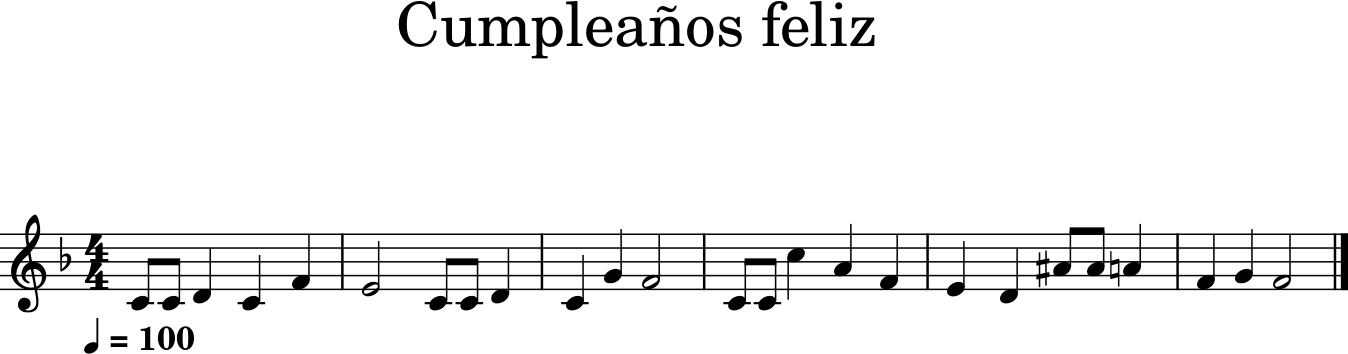

In [14]:
# Display music21 stream
# If you have Musescore installed and configured displays music score - https://musescore.org/en
s.show() # You must have Musescore installed and Configured to run this and display the music score

In [15]:
# Show stream as text
s.show('text')

{0.0} <music21.metadata.Metadata object at 0x1ffb0bdb2e0>
{0.0} <music21.instrument.Piano 'piano'>
{0.0} <music21.tempo.MetronomeMark Quarter=100>
{0.0} <music21.key.Key of F major>
{0.0} <music21.note.Note C>
{0.5} <music21.note.Note C>
{1.0} <music21.note.Note D>
{2.0} <music21.note.Note C>
{3.0} <music21.note.Note F>
{4.0} <music21.note.Note E>
{6.0} <music21.note.Note C>
{6.5} <music21.note.Note C>
{7.0} <music21.note.Note D>
{8.0} <music21.note.Note C>
{9.0} <music21.note.Note G>
{10.0} <music21.note.Note F>
{12.0} <music21.note.Note C>
{12.5} <music21.note.Note C>
{13.0} <music21.note.Note C>
{14.0} <music21.note.Note A>
{15.0} <music21.note.Note F>
{16.0} <music21.note.Note E>
{17.0} <music21.note.Note D>
{18.0} <music21.note.Note A#>
{18.5} <music21.note.Note A#>
{19.0} <music21.note.Note A>
{20.0} <music21.note.Note F>
{21.0} <music21.note.Note G>
{22.0} <music21.note.Note F>


In [16]:
# Save MIdi to file
s.write('midi', 'music21.mid')

'music21.mid'